# Stokes Sinker

Demonstration example for setting up particle swarms with different material properties. This system consists of a dense, high viscosity sphere falling through a background lower density and viscosity fluid. 

In [1]:
import UWGeodynamics as GEO

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
velocity = 1.0 * u.centimeter / u.hour
model_length = 2. * u.meter
model_height = 1. * u.meter
refViscosity = 1e6 * u.pascal * u.second
bodyforce = 200 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_height
Kt = KL / velocity
KM = bodyforce * KL**2 * Kt**2

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM

In [4]:
Model = GEO.Model(elementRes=(64, 64), 
                  minCoord=(-1. * u.meter, -50. * u.centimeter), 
                  maxCoord=(1. * u.meter, 50. * u.centimeter))

In [5]:
lightMaterial = Model.add_material(name="Light", shape=GEO.shapes.Layer2D(top=Model.top, bottom=Model.bottom))
heavyMaterial = Model.add_material(name="Heavy", shape=GEO.shapes.Disk(center=(0.,30.*u.centimetre), radius=10. * u.centimetre))

In [6]:
lightMaterial.density = 10 * u.kilogram / u.metre**3
heavyMaterial.density = 500 * u.kilogram / u.metre**3

lightMaterial.viscosity = GEO.ConstantViscosity(1e6 * u.pascal * u.second)
heavyMaterial.viscosity = GEO.ConstantViscosity(1e6 * u.pascal * u.second)

In [7]:
Model.set_velocityBCs(left=[0, None], right=[0,None], top=[None, 0.], bottom=[None, 0])


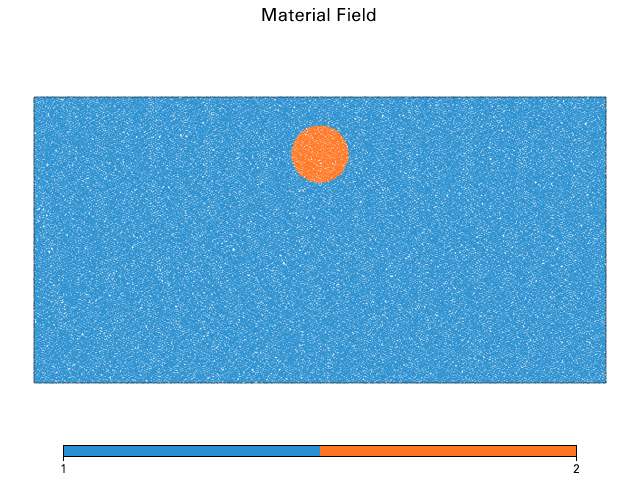

In [8]:
Fig = Model.plot.material(projected=False, fn_size=2.0)

In [9]:
Model.init_model()

In [10]:
!rm -rf outputs/
Model.run_for(1.0 * u.hours)

Running with UWGeodynamics version 0.9.3-dev-7ed5961(development)
Step:1 Model Time:  0.13061856719052997 hour dt: 0.13061856719052997 hour (2018-11-07 01:37:57)
Step:2 Model Time:  0.25929877957914066 hour dt: 0.12868021238861072 hour (2018-11-07 01:37:58)
Step:3 Model Time:  0.3856573510896559 hour dt: 0.1263585715105152 hour (2018-11-07 01:38:00)
Step:4 Model Time:  0.5111900741291426 hour dt: 0.12553272303948676 hour (2018-11-07 01:38:01)
Step:5 Model Time:  0.6346641507696938 hour dt: 0.12347407664055118 hour (2018-11-07 01:38:02)
Step:6 Model Time:  0.7565584633280915 hour dt: 0.12189431255839764 hour (2018-11-07 01:38:04)
Step:7 Model Time:  0.8766259602450174 hour dt: 0.12006749691692589 hour (2018-11-07 01:38:05)
Step:8 Model Time:  0.9952270173627549 hour dt: 0.11860105711773757 hour (2018-11-07 01:38:06)
Step:9 Model Time:  1.0 hour dt: 0.00477298263724512 hour (2018-11-07 01:38:08)


1


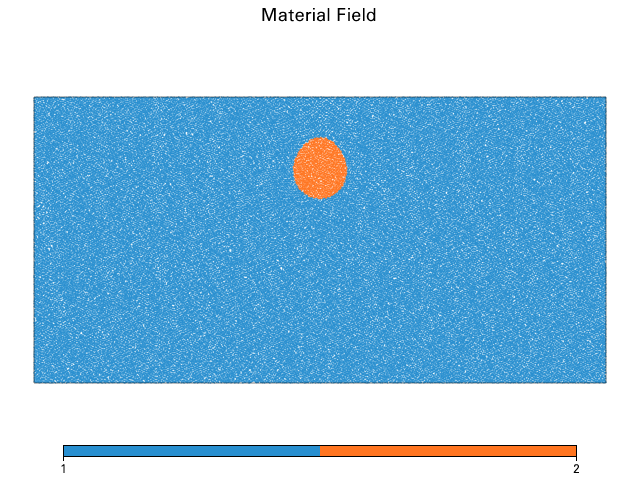

In [11]:
Fig = Model.plot.material(projected=False, fn_size=2.0)


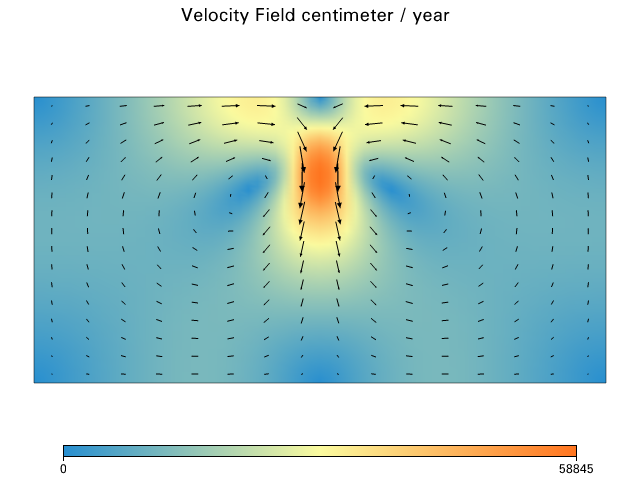

In [12]:
Fig = Model.plot.velocityField()


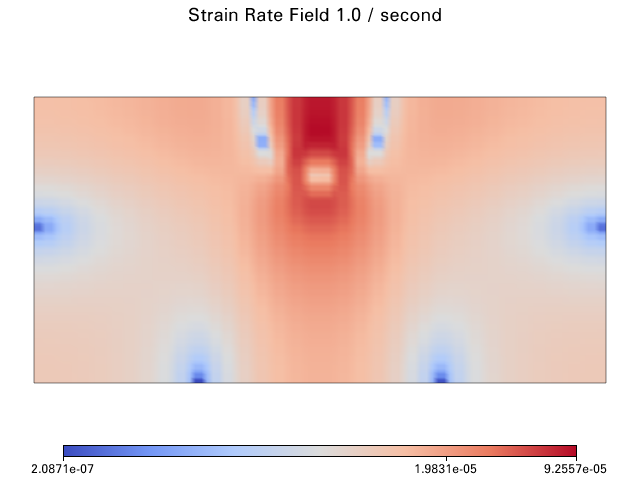

In [13]:
Fig = Model.plot.strainRate()